In [1]:
import argparse
import json
import os
import pickle as pkl
import sys
import time
import warnings
from typing import Union

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import uproot
from coffea import nanoevents, processor
from coffea.nanoevents import BaseSchema, NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray

sys.path.append("../")

import json
import os
import pathlib
import pickle as pkl
import shutil
import warnings
from collections import defaultdict
from typing import List, Optional

import awkward as ak
import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from coffea import processor
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents.methods import candidate, vector

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def pad_val(
    arr: ak.Array,
    value: float,
    target: int = None,
    axis: int = 0,
    to_numpy: bool = False,
    clip: bool = True,
):
    """
    basically: preserves the nested structure of the ak array and replaces None values with -1
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    if target:
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    else:
        ret = ak.fill_none(arr, value, axis=None)
    return ret.to_numpy() if to_numpy else ret

def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
#             "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

def get_pid_mask(
    genparts: GenParticleArray,
    pdgids: Union[int, list],
    ax: int = 2,
    byall: bool = True,
) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) == list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask

In [4]:
# running on
# root://cmseos.fnal.gov//store/user/lpcpfnano/drankin/v2_2/2017/WJetsToLNu/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-100To200/211106_200115/0000/nano_mc2017_1-1.root

In [19]:
! ls ../outfiles/

0-1_ele.parquet  0-1_mu.parquet  0-1.pkl


In [194]:
old = pd.read_parquet("../outfilesold/outfiles/0-5_ele.parquet", filters=[["lep_fj_dr", "<", 0.8]])
old

,fj_msoftdrop,lep_pt,lep_isolation,lep_misolation,lep_fj_dr,lep_met_mt,met_fj_dphi,met_pt,deta,mjj,...,L_btagSFlight_2017Up,L_btagSFlight_2017Down,L_btagSFbc_2017Up,L_btagSFbc_2017Down,L_btagSFlight_correlatedUp,L_btagSFlight_correlatedDown,L_btagSFbc_correlatedUp,L_btagSFbc_correlatedDown,weight_mu,weight_ele
0,24.167390,119.065475,0.718474,0.000000,0.090115,75.421257,2.189562,14.468851,2.214783,214.936279,...,0.995445,0.995178,0.997911,0.991843,0.995407,0.995217,0.997109,0.993107,1.502497,1.503789
1,95.244769,64.717102,0.000000,0.000000,0.417019,23.582958,0.312709,49.522247,NaN,NaN,...,0.327236,0.287633,0.307598,0.307598,0.321726,0.293300,0.307598,0.307598,1.465581,1.426363
2,91.984312,50.384544,0.019467,0.019471,0.435228,68.267258,2.717904,27.253942,0.567627,68.779877,...,0.554889,0.499390,0.527733,0.527733,0.546971,0.507904,0.527733,0.527733,1.500397,1.448191
3,56.494671,61.858627,0.000000,0.000000,0.388965,88.155411,-1.869926,39.349003,NaN,NaN,...,0.263304,0.230705,0.247108,0.247108,0.258750,0.235358,0.247108,0.247108,1.468193,1.449492
4,51.427469,158.847366,0.007645,0.000000,0.087791,19.440250,0.211057,51.423164,2.028931,290.408051,...,0.922720,0.921048,0.935384,0.908388,0.922511,0.921259,0.933418,0.910353,1.416018,1.444139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,62.393388,129.419525,0.047077,0.054163,0.193955,90.963432,1.350337,39.518272,NaN,NaN,...,0.443294,0.392232,0.418040,0.418040,0.435871,0.399926,0.418040,0.418040,1.609638,1.634851
776,32.883656,172.321274,0.099520,0.000000,0.059473,147.982910,-2.898687,32.075394,2.648224,258.400848,...,0.373490,0.327772,0.350824,0.350824,0.367366,0.334083,0.350824,0.350824,1.296622,1.190102
777,97.318975,75.228043,0.000000,0.000000,0.443834,98.127815,-2.862783,32.788700,NaN,NaN,...,0.297208,0.260786,0.279148,0.279148,0.292322,0.265814,0.279148,0.279148,1.309402,1.251323
778,0.000000,181.681595,0.032323,0.000000,0.032027,11.182274,-0.386769,4.365685,1.720825,204.353668,...,0.964404,0.960767,0.975030,0.950198,0.963880,0.961319,0.965971,0.959257,1.686964,1.720568


In [195]:
new = pd.read_parquet("../outfilesnew/0-5_ele.parquet", filters=[["lep_fj_dr", "<", 0.8]])
new

,fj_msoftdrop,lep_pt,lep_isolation,lep_misolation,lep_fj_dr,lep_met_mt,met_fj_dphi,met_pt,deta,mjj,...,L_btagSFlight_2017Up,L_btagSFlight_2017Down,L_btagSFbc_2017Up,L_btagSFbc_2017Down,L_btagSFlight_correlatedUp,L_btagSFlight_correlatedDown,L_btagSFbc_correlatedUp,L_btagSFbc_correlatedDown,weight_mu,weight_ele
0,24.167390,119.065475,0.718474,0.000000,0.090115,75.421257,2.189562,14.468851,2.214783,214.936279,...,0.995445,0.995178,0.997911,0.991843,0.995407,0.995217,0.997109,0.993107,1.411814,1.413028
1,95.244769,64.717102,0.000000,0.000000,0.417019,23.582958,0.312709,49.522247,NaN,NaN,...,0.327236,0.287633,0.307598,0.307598,0.321726,0.293300,0.307598,0.307598,1.426016,1.387857
2,91.984312,50.384544,0.019467,0.019471,0.435228,68.267258,2.717904,27.253942,0.567627,68.779877,...,0.554889,0.499390,0.527733,0.527733,0.546971,0.507904,0.527733,0.527733,1.488744,1.436944
3,56.494671,61.858627,0.000000,0.000000,0.388965,88.155411,-1.869926,39.349003,NaN,NaN,...,0.263304,0.230705,0.247108,0.247108,0.258750,0.235358,0.247108,0.247108,1.440725,1.422373
4,51.427469,158.847366,0.007645,0.000000,0.087791,19.440250,0.211057,51.423164,2.028931,290.408051,...,0.922720,0.921048,0.935384,0.908388,0.922511,0.921259,0.933418,0.910353,1.230364,1.254798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,62.393388,129.419525,0.047077,0.054163,0.193955,90.963432,1.350337,39.518272,NaN,NaN,...,0.443294,0.392232,0.418040,0.418040,0.435871,0.399926,0.418040,0.418040,1.421171,1.443433
776,32.883656,172.321274,0.099520,0.000000,0.059473,147.982910,-2.898687,32.075394,2.648224,258.400848,...,0.373490,0.327772,0.350824,0.350824,0.367366,0.334083,0.350824,0.350824,1.166295,1.070481
777,97.318975,75.228043,0.000000,0.000000,0.443834,98.127815,-2.862783,32.788700,NaN,NaN,...,0.297208,0.260786,0.279148,0.279148,0.292322,0.265814,0.279148,0.279148,1.289356,1.232166
778,0.000000,181.681595,0.032323,0.000000,0.032027,11.182274,-0.386769,4.365685,1.720825,204.353668,...,0.964404,0.960767,0.975030,0.950198,0.963880,0.961319,0.965971,0.959257,1.499480,1.529349


(200.0, 504.0)

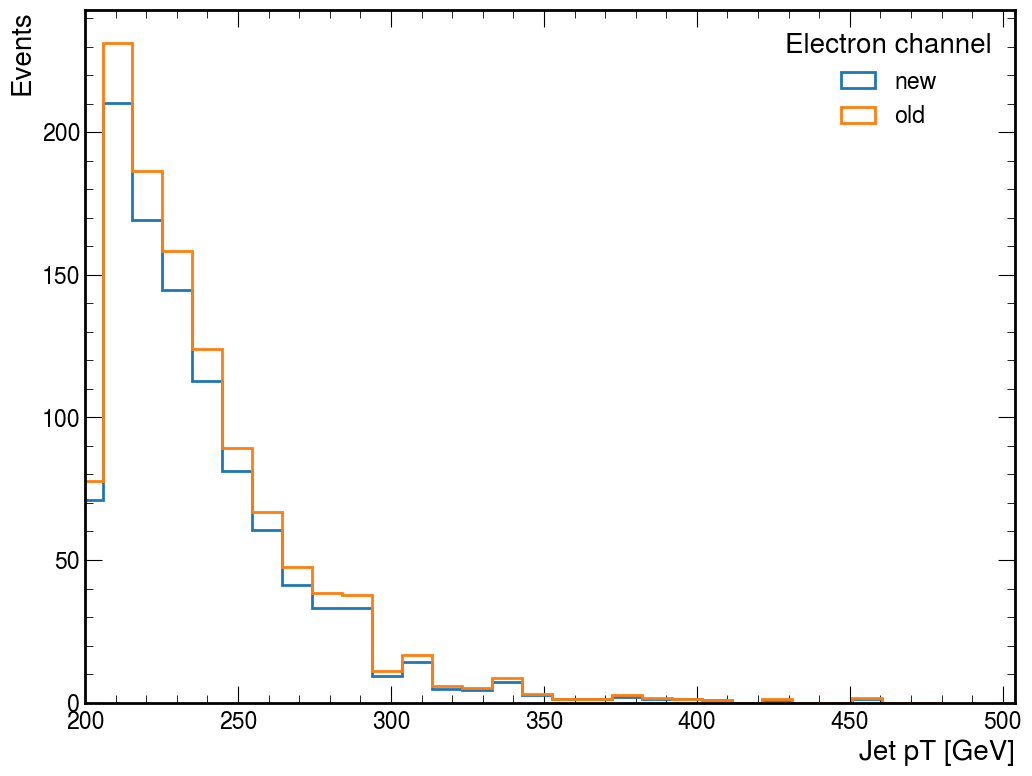

In [203]:
plt.rcParams.update({"font.size": 20})

bins = 50

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "TTbar"
channels = ["ele", "mu"]
region = "signal_region"

fig, ax = plt.subplots(figsize=(12, 9))

ax.hist(
    new["fj_pt"], 
    bins=np.linspace(0,480,bins), 
    weights=new["weight_ele"],
#     density=True, 
    histtype="step", 
    linewidth=2, 
    label="new",
)

ax.hist(
    old["fj_pt"], 
    bins=np.linspace(0,480,bins), 
    weights=old["weight_ele"],
#     density=True, 
    histtype="step", 
    linewidth=2, 
    label="old",
)

# ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")
ax.legend(title="Electron channel")
ax.set_ylabel("Events")
ax.set_xlabel(f"Jet pT [GeV]")
ax.set_xlim(200)

In [204]:
new["weight_ele"].sum()

1010.9039288541674

In [206]:
old["weight_ele"].sum()

1121.2021400667722

In [182]:
new["weight_ele"].sum()

12.491738389188763

In [7]:
# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"root://cmseos.fnal.gov//store/user/lpcpfnano/drankin/v2_2/2017/WJetsToLNu/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-100To200/211106_200115/0000/nano_mc2017_1-1.root")
num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()

number of events per file is 72418


In [9]:
def get_vpt(genpart, check_offshell=False):
    """Only the leptonic samples have no resonance in the decay tree, and only
    when M is beyond the configured Breit-Wigner cutoff (usually 15*width)
    """
    boson = ak.firsts(
        genpart[((genpart.pdgId == 23) | (abs(genpart.pdgId) == 24)) & genpart.hasFlags(["fromHardProcess", "isLastCopy"])]
    )
    if check_offshell:
        offshell = genpart[
            genpart.hasFlags(["fromHardProcess", "isLastCopy"])
            & ak.is_none(boson)
            & (abs(genpart.pdgId) >= 11)
            & (abs(genpart.pdgId) <= 16)
        ].sum()
        return ak.where(ak.is_none(boson.pt), offshell.pt, boson.pt)
    return np.array(ak.fill_none(boson.pt, 0.0))

In [18]:
genpart = events.GenPart
vpt = get_vpt(genpart)
vpt

array([39.25   , 38.125  , 81.5    , ..., 55.5    , 35.5    , 12.34375])

In [39]:
# old
import importlib.resources
import pickle
import warnings
from typing import Dict

import awkward as ak
import correctionlib
import numpy as np
from coffea import util as cutil
from coffea.analysis_tools import Weights
from coffea.nanoevents.methods.nanoaod import JetArray

with importlib.resources.path("boostedhiggs.data", "ULvjets_corrections.json") as filename:
    vjets_kfactors = correctionlib.CorrectionSet.from_file(str(filename))
    
qcdcorr = vjets_kfactors["ULW_MLMtoFXFX"].evaluate(vpt)  # replace
ewkcorr = vjets_kfactors["W_FixedOrderComponent"]  # keep
ewknom = ewkcorr.evaluate("nominal", vpt)
print("qcdcorr", qcdcorr)
print("ewknom", ewknom)
print("qcdcorr*ewknom", qcdcorr*ewknom)

qcdcorr [1.57546211 1.57546211 1.57546211 ... 1.57546211 1.57546211 1.57546211]
ewknom [0.99658845 0.99658845 0.98062954 ... 0.99052354 0.99658845 0.99658845]
qcdcorr*ewknom [1.57008734 1.57008734 1.54494468 ... 1.5605323  1.57008734 1.57008734]


In [ ]:
"""
Bhadrons       Systematic
 0             1.628±0.005 - (1.339±0.020)·10−3 pT(V)
 1             1.586±0.027 - (1.531±0.112)·10−3 pT(V)
 2             1.440±0.048 - (0.925±0.203)·10−3 pT(V)
"""


0.001

In [42]:
boson = ak.firsts(
    genpart[((genpart.pdgId == 23) | (abs(genpart.pdgId) == 24)) & genpart.hasFlags(["fromHardProcess", "isLastCopy"])]
)

<Array [[True, True, True, ... False, False]] type='72418 * var * bool'>

In [212]:
(np.abs(genjets.eta)<2.4)

<Array [[0.859, 0.304, 0.997, ... 4.33, 2.14]] type='72418 * var * float32'>

In [213]:
genjets = events.GenJet
goodgenjets = genjets[(genjets.pt>25.0) & (np.abs(genjets.eta)<2.4)]

nB0 = (ak.sum(goodgenjets.hadronFlavour==5, axis=1) == 0).to_numpy()
nB1 = (ak.sum(goodgenjets.hadronFlavour==5, axis=1) == 1).to_numpy()
nB2 = (ak.sum(goodgenjets.hadronFlavour==5, axis=1) == 2).to_numpy()

nB0

array([ True,  True,  True, ..., False,  True,  True])

In [173]:
qcdcorrnew = np.zeros_like(vpt)

qcdcorrnew[nB0] = 1.628 - (1.339*1e-3*vpt[nB0])
qcdcorrnew[nB1] = 1.586 - (1.531*1e-3*vpt[nB1])
qcdcorrnew[nB2] = 1.440 - (0.925*1e-3*vpt[nB2])

qcdcorrnew

array([1.57544425, 1.57695062, 1.5188715 , ..., 1.5010295 , 1.5804655 ,
       1.61147172])

In [168]:
qcdcorr

array([1.57546211, 1.57546211, 1.57546211, ..., 1.57546211, 1.57546211,
       1.57546211])

In [171]:
events.GenPart

<GenParticleArray [[GenParticle, ... GenParticle]] type='72418 * var * genParticle'>

In [113]:
sum(nB0 + nB1 + nB2)

72398

In [109]:
nB1

<Array [False, False, False, ... False, False] type='72418 * bool'>

In [74]:
genjets

<PtEtaPhiMCollectionArray [[{eta: -0.859, ... hadronFlavour: 0}]] type='72418 * ...'>

In [76]:
genjets[0]

<PtEtaPhiMCollectionArray [{eta: -0.859, ... hadronFlavour: 0}] type='5 * struct...'>

In [79]:
boson[0].pt

39.25

In [84]:
ak.argmin(boson[1].delta_r(genjets[1]))

3

In [94]:
boson

<GenParticleArray [GenParticle, ... GenParticle] type='72418 * ?genParticle'>

In [97]:
genjets = events.GenJet
genjets

<PtEtaPhiMCollectionArray [[{eta: -0.859, ... hadronFlavour: 0}]] type='72418 * ...'>

In [99]:
event_idx = 1
boson[event_idx].delta_r(genjets[event_idx])

<Array [3.99, 6.31, 4.24, 3.64] type='4 * float32'>

In [88]:
event_idx = 1
boson[event_idx].delta_r(genjets[event_idx])

<Array [3.99, 6.31, 4.24, 3.64] type='4 * float32'>

In [91]:
boson.fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

In [93]:
boson[0]

GenParticle

<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 1, 0, 0] type='72418 * int64'>